<font color='blue'> **37-ex-gwt-mt3dms-p01** </font> 
<font color='red'> **_______________________________ 1D _______________________________** </font> 

In [8]:
import os ; from pathlib import Path ; from pprint import pformat ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np
from modflow_devtools.misc import get_env ;write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)
_R = Path("_R")   ; _R.mkdir(exist_ok=True); DA = Path('_R/37-ex-gwt-mt3dms-p01'); DA.mkdir(exist_ok=True)   ; from flopy.plot.styles import styles ; import pandas as pd 

In [9]:
parameters = {"ex-gwt-mt3dms-p01a": {"dispersivity": 0.0 ,"retardation": 1.0,"decay": 0.0,} ,"ex-gwt-mt3dms-p01b": {"dispersivity": 10.0,"retardation": 1.0,"decay": 0.0,},
              "ex-gwt-mt3dms-p01c": {"dispersivity": 10.0,"retardation": 5.0,"decay": 0.0,} ,"ex-gwt-mt3dms-p01d": {"dispersivity": 10.0,"retardation": 5.0,"decay": 0.002,},}
parameter_units = {"dispersivity": "$m$","retardation": "unitless","decay": "$d^{-1}$",}  ; length_units = "meters" ; time_units = "days"       #; list(parameters.keys())[0]

nlay=1;ncol=101;nrow=1  ;delr=10.0;delc=1.0  ;Lx=(ncol-1)*delr     ;top=0.0;botm=-1.0  ;prsity=0.25;k11=k33=1.0;laytyp=1      ;perlen=2000;nper=1;nstp=100.0 #; dt0=perlen/nstp         

IC_sconc = np.zeros((nlay,nrow,ncol), dtype=float)   ;dmcoef = 0.0             ;nouter, ninner = 100, 300   ; v=0.24 ;q=v*prsity ;h1=q*Lx
strt     = np.zeros((nlay,nrow,ncol), dtype=float)   ;strt[0, 0, 0] = h1       ;l = 1000.0                  ; icelltype = 1  
ibound   = np.ones ((nlay,nrow,ncol), dtype=int)     ;ibound[0, 0, 0] = -1     ;ibound[0, 0, -1] = -1       ; mixelm = 0 ;    rhob = 0.25 ; sp2 = 0.0  
hclose,rclose,relax = 1e-6, 1e-6, 1.0                ;npmax = 8                ;nlsink = nplane =1          ; npsink = nph =4   ; tdis_rc = []                                              

tdis_rc.append((perlen, nstp, 1.0))  ;chdspd=[[(0, 0, 0), h1], [(0, 0, ncol - 1), 0.0]]        ;c0=1.0;cncspd=[[(0,0,0),c0]] #; npl = 0   #ttsmult=1.0;dceps=1.0e-5;npmin=0 # HMOC

In [10]:
def build_models(sim_name,dispersivity=0.0,retardation=0.0,decay=0.0,silent=False):     
    global sim ,gwf, gwt 
    c0 = 1.0 ; name   = "p01"                        ; GWF = "gwf-" + name    ; GWT = "gwt-" + name                                   ; DB = os.path.join(DA/sim_name)
    icbund = np.ones((nlay, nrow, ncol), dtype=int)      ; icbund[0,0,0]=-1       ; IC_sconc = np.zeros((nlay, nrow, ncol), dtype=float)  ; IC_sconc  [0, 0, 0] = c0
    
    sim    = flopy.mf6.MFSimulation (sim_name=sim_name, sim_ws=DB)
    tdis   = flopy.mf6.ModflowTdis  (sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    gwf    = flopy.mf6.ModflowGwf   (sim,modelname=GWF,save_flows=True,model_nam_file=f"{GWF}.nam")
    imsgwf = flopy.mf6.ModflowIms   (sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,
                                         linear_acceleration="CG",scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename=f"{GWF}.ims")                                        
    sim.register_ims_package(imsgwf,[gwf.name])                                                                                               ;IDO = np.ones((nlay, nrow, ncol), dtype=int)
    dis = flopy.mf6.ModflowGwfdis   (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=IDO,filename=f"{GWF}.dis")
    npf = flopy.mf6.ModflowGwfnpf   (gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True,filename=f"{GWF}.npf")
    fic = flopy.mf6.ModflowGwfic    (gwf, strt=strt, filename=f"{GWF}.ic")                                                    ; HEA=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")]
    chd = flopy.mf6.ModflowGwfchd   (gwf,maxbound=len(chdspd),stress_period_data=chdspd,save_flows=False,pname="CHD-1",filename=f"{GWF}.chd") ; SA=[("HEAD", "LAST"), ("BUDGET", "LAST")]
    foc = flopy.mf6.ModflowGwfoc    (gwf,head_filerecord=f"{GWF}.hds",budget_filerecord=f"{GWF}.cbc",headprintrecord=HEA,saverecord=SA,printrecord=SA)      
    
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6"  , modelname=GWT  , model_nam_file=f"{GWT}.nam")                            ; gwt.name_file.save_flows = True
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation=       "NONE",inner_maximum=ninner,inner_dvclose=hclose,
                                  rcloserecord=rclose,linear_acceleration="BICGSTAB",scaling_method="NONE",reordering_method=  "NONE",relaxation_factor=relax,filename=f"{GWT}.ims",)
    sim.register_ims_package(imsgwt, [gwt.name])    ;     dis = flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=1,filename=f"{GWT}.dis")
    ic = flopy.mf6.ModflowGwtic(gwt, strt=IC_sconc, filename=f"{GWT}.ic")
    if      mixelm == 0:    scheme = "UPSTREAM"
    elif    mixelm == -1:   scheme = "TVD"
    else:   raise Exception()  
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{GWT}.adv")
    if dispersivity != 0:   dsp = flopy.mf6.ModflowGwtdsp(gwt,xt3d_off=True,alh=dispersivity,ath1=dispersivity,filename=f"{GWT}.dsp",)
    if retardation != 1.0:  sorption = "linear"        ; bulk_density = rhob    ; kd = (retardation - 1.0) * prsity / rhob  
    else:                   sorption = None            ; bulk_density = None    ; kd = None
    if decay != 0.0:        first_order_decay = True   ; decay_arg = decay
    else:                   first_order_decay = False  ; decay_arg = None
    mst = flopy.mf6.ModflowGwtmst  (gwt,porosity=prsity,sorption=sorption,bulk_density=bulk_density,distcoef=kd,first_order_decay=first_order_decay,
                                    decay=decay_arg,decay_sorbed=decay_arg,filename=f"{GWT}.mst")                            ;SA=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")]
    cnc = flopy.mf6.ModflowGwtcnc  (gwt,maxbound=len(cncspd),stress_period_data=cncspd,save_flows=False,pname="CNC-1",filename=f"{GWT}.cnc",)
    ssm = flopy.mf6.ModflowGwtssm  (gwt, sources=[[]], filename=f"{GWT}.ssm")                                                ;CO=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")]
    toc = flopy.mf6.ModflowGwtoc   (gwt,budget_filerecord=f"{GWT}.cbc",concentration_filerecord=f"{GWT}.ucn",concentrationprintrecord=CO,saverecord=SA,printrecord=SA,)
    flopy.mf6.ModflowGwfgwt        (sim,exgtype="GWF6-GWT6",exgmnamea=GWF,exgmnameb=GWT,filename=f"{name}.gwfgwt")                       ; return sim

def write_models (sim, silent=True):   sim.write_simulation(silent=silent)
def run_models(sim, silent=True):      success, buff = sim.run_simulation(silent=silent, report=True)  ; assert success, pformat(buff)

def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]          ; parameter_dict = parameters[key]       ;sim = build_models(key, **parameter_dict)
    if write: write_models(sim, silent=silent)
    if run:   run_models(sim, silent=silent)    # if plot:  plot_results(sim, idx)
scenario(0) ; scenario(1); scenario(2); scenario(3)

In [11]:
DC = list(os.listdir(DA)) ; print('DC:',DC)
F3 = os.path.join(DA/DC[0]/'gwf-p01.hds');hdobj=flopy.utils.HeadFile(F3)   ;AA=hdobj.get_data()  ; F3 = os.path.join(DA/DC[2]/'gwf-p01.hds');hdobj=flopy.utils.HeadFile(F3)    ;CC=hdobj.get_data()
sim.set_sim_path(os.path.join(DA/DC[0])) ; gwt = sim.get_model(list(sim.model_names)[1])         ; ucnobj = gwt.output.concentration()  ; A = ucnobj.get_alldata() 
sim.set_sim_path(os.path.join(DA/DC[1])) ; gwt = sim.get_model(list(sim.model_names)[1])         ; ucnobj = gwt.output.concentration()  ; B = ucnobj.get_alldata() 
sim.set_sim_path(os.path.join(DA/DC[2])) ; gwt = sim.get_model(list(sim.model_names)[1])         ; ucnobj = gwt.output.concentration()  ; C = ucnobj.get_alldata() 
sim.set_sim_path(os.path.join(DA/DC[3])) ; gwt = sim.get_model(list(sim.model_names)[1])         ; ucnobj = gwt.output.concentration()  ; D = ucnobj.get_alldata() 
df=pd.concat([pd.DataFrame(np.linspace(0,l,ncol)),pd.DataFrame(A[0,0,0,:]),pd.DataFrame(B[0,0,0,:]),pd.DataFrame(C[0,0,0,:]),pd.DataFrame(D[0,0,0,:])],axis=1);df.columns=['time','A','B','C','D']

DC: ['ex-gwt-mt3dms-p01a', 'ex-gwt-mt3dms-p01b', 'ex-gwt-mt3dms-p01c', 'ex-gwt-mt3dms-p01d']


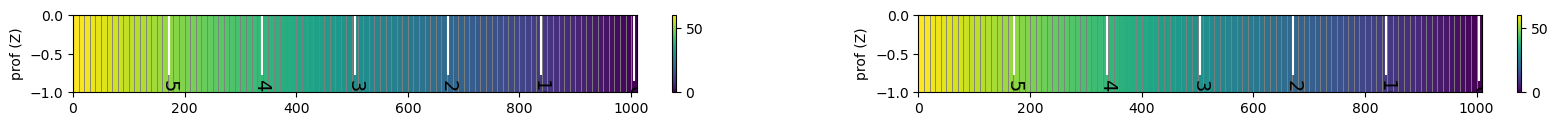

In [12]:
fig = plt.figure(figsize=(20, 1))                    
ax = fig.add_subplot(121) ; XS=flopy.plot.PlotCrossSection(model=gwf,line={'Row':0})  ;NN = AA  ; mn=XS.contour_array(NN,colors='white') ; HV=XS.plot_array(NN, head=NN)   
plt.clabel(mn,colors='black',fontsize=14) ; fig.colorbar(HV,orientation='vertical')             ; plt.ylabel('prof (Z)')    ; XS.plot_grid(lw=0.5) ; 
ax = fig.add_subplot(122) ; XS=flopy.plot.PlotCrossSection(model=gwf,line={'Row':0})  ;NN = CC  ; mn=XS.contour_array(NN,colors='white') ; HV=XS.plot_array(NN, head=NN)   
plt.clabel(mn,colors='black',fontsize=14) ; fig.colorbar(HV,orientation='vertical'); plt.ylabel('prof (Z)') ; XS.plot_grid(lw=0.5) ; plt.show()

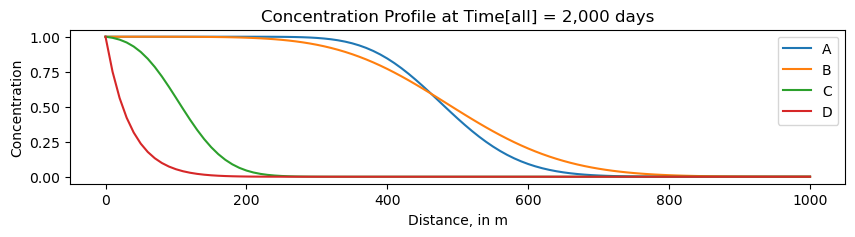

[{'dispersivity': 0.0, 'retardation': 1.0, 'decay': 0.0},
 {'dispersivity': 10.0, 'retardation': 1.0, 'decay': 0.0},
 {'dispersivity': 10.0, 'retardation': 5.0, 'decay': 0.0},
 {'dispersivity': 10.0, 'retardation': 5.0, 'decay': 0.002}]

In [13]:
title = f"Concentration Profile at Time[all] = 2,000 {time_units}"
ax = df.plot(x='time', y=['A','B','C','D'], kind='line', figsize=(10, 2),title=title); ax.set_xlabel("Distance, in m"); ax.set_ylabel("Concentration")
plt.show() ; list(parameters.values())

In [14]:
#def plot_results( mf6, idx, ax=None):
#    mf6.simulation_data.mfpath.get_sim_path()  ;gwt = mf6.get_model(list(mf6.model_names)[1])    ; ucnobj = gwt.output.concentration()  ; conc_mf6 = ucnobj.get_alldata()
#    with styles.USGSPlot() as fs: 
#        sim_name = mf6.name
#        if ax is None:
#            fig, ax = plt.subplots(1, 1, figsize=(6, 2), dpi=100, tight_layout=True)
#        ax.plot(np.linspace(0, l, ncol), conc_mf6  [0,0,0,:], "^" , markeredgewidth=0.5  ,color="blue" ,fillstyle="none" ,label="MF6",markersize=3)
#       ax.set_ylim(0, 1.2)  ;   ax.set_xlim(0, 1000)   ; ax.set_xlabel("Distance, in m")    ; ax.set_ylabel("Concentration") ; 
#        title = f"Concentration Profile at Time = 2,000 {time_units}"  ; ax.legend()         ; letter = chr(ord("@") + idx + 1)     
#        styles.heading(letter=letter, heading=title);             plt.show()